<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 8.2MB 11.0MB/s 


## Dataset

Посмотрим на то, как устроен датасет

In [3]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [4]:
# Importing libraries
import json
import random
import math
import razdel
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

from tqdm.notebook import tqdm
import torch
import numpy as np

import time 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from numpy import exp
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
import copy

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [5]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [6]:
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [7]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 9.1MB/s 


In [8]:
import youtokentome as yttm
def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [9]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [10]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

### Составление батчей

In [ ]:
# Class counts
#class_0_count = tensor(53870.)
#class_1_count = tensor(4487.)

In [11]:

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            #tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)
            tensor_outputs = torch.ones((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)*2

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
ext_train_records[0]["date"]

'2011-11-30 18:33:39'

In [13]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

In [14]:
# Let's see what is in the first batch
next(iter(train_iterator)).keys()

dict_keys(['inputs', 'outputs', 'records'])

In [15]:
next(iter(train_iterator))['inputs']

tensor([[[ 276, 3008,  633,  ...,    0,    0,    0],
         [ 472, 2000,  290,  ..., 1352,  897,  501],
         [5262,  855, 6208,  ...,    0,    0,    0],
         ...,
         [1894,  879,  318,  ...,    0,    0,    0],
         [ 485,  506, 6856,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[ 615, 1445, 2956,  ...,    0,    0,    0],
         [4160,  340, 1541,  ...,    0,    0,    0],
         [ 322, 2978, 3575,  ...,  546,    5,  989],
         ...,
         [3373, 1245,  276,  ...,    0,    0,    0],
         [ 991,  344,  276,  ...,    0,    0,    0],
         [ 454,  812, 5912,  ...,  715,  463,  878]],

        [[8857,   60, 4745,  ...,    0,    0,    0],
         [ 422, 2425,   16,  ...,  445, 3343,  395],
         [3213,   25, 1862,  ...,    0,    0,    0],
         ...,
         [ 809,  945,  400,  ..., 1456,  749,  906],
         [ 286,  693,  862,  ...,    0,    0,    0],
         [1018,  286, 8460,  ...,    0,    0,    0]],

In [ ]:
next(iter(train_iterator))['outputs'].shape

torch.Size([32, 30])

In [16]:
next(iter(train_iterator))['records'][0]

{'date': '2018-11-24 13:30:50',
 'oracle_sentences': [0, 18],
 'oracle_summary': 'в керчи разрушается митридатская лестница — одна из главных достопримечательностей крымского полуострова и визитная карточка города. здесь гуляют бродячие собаки и бездомные кошки.',
 'sentences': ['в керчи разрушается митридатская лестница — одна из главных достопримечательностей крымского полуострова и визитная карточка города.',
  'исторический памятник середины xix века, входящий в реестр объектов культурного наследия россии федерального значения, находится в аварийном состоянии.',
  'то, что могло бы служить приманкой для туристов, поток которых значительно увеличился через восточные ворота крыма с введением в строй транспортного моста, представляет опасность для жизни.',
  'из-за отсутствия необходимого ремонта в 2015 году митридатская лестница пережила частичное обрушение.',
  'в частности, пострадал возведенный у ее основания склеп деметры, треснул и продолжил разрушаться арочный свод.',
  'часть 

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когда вы выбираете предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

## Model without novelty

$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [17]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=False,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2) # YOUR CODE
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
        return content + salience

In [18]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [19]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [20]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!cd /content/gdrive/My\ Drive/

Mounted at /content/gdrive


In [21]:
!gdown https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0 -O train_model.py 
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

Downloading...
From: https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0
To: /content/train_model.py
100% 4.74k/4.74k [00:00<00:00, 7.79MB/s]


In [ ]:
#torch.cuda.empty_cache()

## Training with class weights

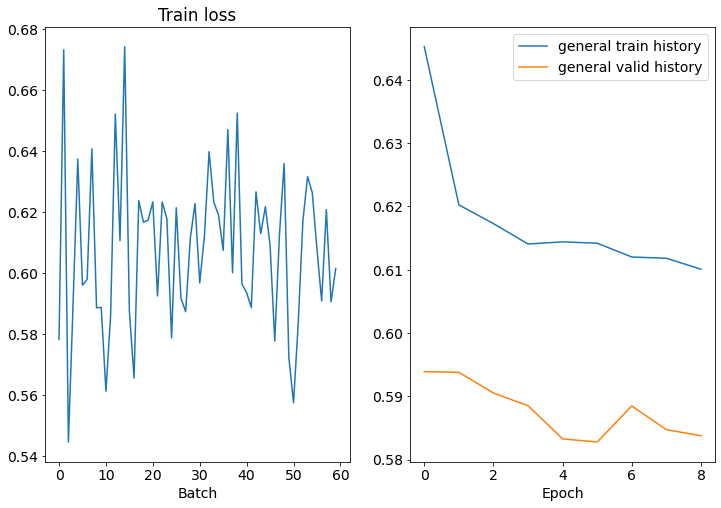

Epoch: 10 | Time: 0m 9s
	Train Loss: 0.609 | Train PPL:   1.838
	 Val. Loss: 0.589 |  Val. PPL:   1.802


In [22]:
N_EPOCHS = 10
CLIP = 1.0


def train(use_class_weights, N_EPOCHS, CLIP, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr)

    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE
        weights = [0.077, 0.923] #as class distribution
        class_weights = torch.FloatTensor(weights).cuda()
        criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=2) 
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=2)  

    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

train(True, N_EPOCHS, CLIP)

In [23]:
from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
    
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]
                            if ind < len(batch["records"][i]["sentences"])])
            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

model.load_state_dict(torch.load('weights_best-val-model.pt'))
inference_summarunner_without_novelty_with_class_weights = inference_summarunner(model, test_iterator, 3)
inference_summarunner_without_novelty_with_class_weights

Count: 256
Ref: посол рф в израиле анатолий викторов заявил , что за прошлый год тель-авив отказал россиянам во въезде в страну почти 6 тыс . раз , причем часть отказов ничем не обоснованы . по словам дипломата , среди « отказников » — туристы и паломники , четко выполнившие поставленные условия . он выразил надежду , что благодаря совместной работе рф и израиля ситуацию удастся изменить .
Hyp: за 2019 год израиль отказал россиянам во въезде в страну около 6 тыс . раз . об этом сообщает принадлежащее григорию березкину рбк со ссылкой на посла россии в израиле анатолия викторова . « среди них — туристы и паломники , которые абсолютно четко , с их точки зрения , выполнили все условия : купили билеты , путевки , забронировали гостиницы , располагали достаточным количеством финансовых средств — однако въехать в израиль им не разрешили » , — заявил дипломат .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536896, 'p': 0.30313415143950323, 'r': 0.3531967563454292}, 'rouge-2

In [24]:
from train_model import punct_detokenize, postprocess
def inference_summarunner_with_threshold(model, iterator, threshold = 0):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
    
        sum_in = (logits > threshold).nonzero(as_tuple=False)
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]
                            if ind < len(batch["records"][i]["sentences"])])
            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

model.load_state_dict(torch.load('weights_best-val-model.pt'))
inference_summarunner_without_novelty_and_threshold = inference_summarunner_with_threshold(model, test_iterator, -0.47)
inference_summarunner_without_novelty_and_threshold

Count: 256
Ref: накопительная часть пенсии не будет разморожена . по крайней мере до 2022 года включительно . это следует из подписанного президентом владимиром путиным закона . накопительная часть пенсии была заморожена еще в 2014 году и позволила пфр сэкономить более двух триллионов рублей . надежд на будущую « разморозку » все меньше . чиновники рассчитывают , что россияне будут копить на достойную старость самостоятельно .
Hyp: соответствующий федеральный закон подписал президент россии владимир путин . до этого текст законопроекта приняла госдума и одобрил совет федерации .
BLEU:  0.40200541727836503
ROUGE:  {'rouge-1': {'f': 0.2746113271189235, 'p': 0.31716730346814564, 'r': 0.258780831809688}, 'rouge-2': {'f': 0.11533904803441995, 'p': 0.1335784699035191, 'r': 0.11006570595957325}, 'rouge-l': {'f': 0.2289028268242449, 'p': 0.2822534788094235, 'r': 0.22961746324293203}}


## Training without class weights

In [25]:
!gdown https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0 -O train_model.py 
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

Downloading...
From: https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0
To: /content/train_model.py
100% 4.75k/4.75k [00:00<00:00, 7.37MB/s]


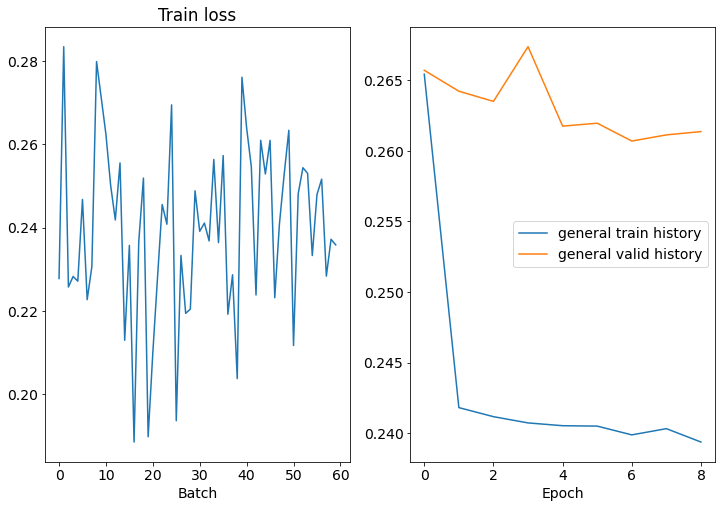

Epoch: 10 | Time: 0m 9s
	Train Loss: 0.239 | Train PPL:   1.270
	 Val. Loss: 0.262 |  Val. PPL:   1.299


In [26]:
N_EPOCHS = 10
CLIP = 1.0

train(False, N_EPOCHS, CLIP)

In [27]:
from train_model import punct_detokenize, postprocess


model.load_state_dict(torch.load('without_class_weights_best-val-model.pt'))
inference_summarunner_without_novelty_without_class_weights = inference_summarunner(model, test_iterator, 3)
inference_summarunner_without_novelty_without_class_weights

Count: 256
Ref: в конце 2019 года все больше россиян стали экономить — причем практически на всем . они сокращали траты на покупку одежды и бытовой техники , развлечения . даже старались реже пользоваться личным автомобилем , поскольку это затратно . по итогам прошлого года доходы наших соотечественников выросли всего на 0,8 % . и в этом году надеяться особо не на что , предупреждают эксперты .
Hyp: россияне все чаще стараются экономить , показал квартальный опрос . в том , что приходится ужиматься в тратах , признались 70 % респондентов . глобальное исследование потребительского доверия the conference board проводилось совместно с nielsen .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.3173318124753689, 'p': 0.30313415143950345, 'r': 0.3531967563454292}, 'rouge-2': {'f': 0.14277322190268435, 'p': 0.1347593218711489, 'r': 0.16339726182715175}, 'rouge-l': {'f': 0.27154623032757474, 'p': 0.2739258120398611, 'r': 0.3186041265424391}}


In [36]:
from train_model import punct_detokenize, postprocess

model.load_state_dict(torch.load('without_class_weights_best-val-model.pt'))
inference_summarunner_without_novelty_with_threshold = inference_summarunner_with_threshold(model, test_iterator, -2)
inference_summarunner_without_novelty_with_threshold

Count: 256
Ref: рекордное снижение спроса на бензин зафиксировано в россии в 2019 году . по данным аналитиков , спрос упал на 1 % в сравнении с прошлогодними показателями . снижение интереса к бензину может быть связано с падением реальных доходов российских граждан , а не с ценами на топливо . автомобиль просто стал « дорогим удовольствием » .
Hyp: об этом сообщают « известия » , публикуя результаты исследования группы « петромаркет » и агентства « аналитика товарных рынков » . об этом сообщают « известия » , публикуя результаты исследования группы « петромаркет » и агентства « аналитика товарных рынков » .
BLEU:  0.4073267984472872
ROUGE:  {'rouge-1': {'f': 0.2800724387822019, 'p': 0.3274300537144721, 'r': 0.26364070523755756}, 'rouge-2': {'f': 0.1220463964908466, 'p': 0.14297612851627922, 'r': 0.11668058121579149}, 'rouge-l': {'f': 0.23357871508449574, 'p': 0.2944439072259674, 'r': 0.2365671133639738}}


## Model with novelty


In [39]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNNWithNovelty(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2) # YOUR CODE
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE
            summary_representation = torch.zeros(batch_size, 1, 2*self.hidden_size).to(device)
            for sentence_num in range(sentences_count):
                # YOUR CODE
                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                sentence_num_state = outputs[:, sentence_num, :].unsqueeze(1) # [batch_size, seq num, hidden_size]
                # 2) calculate novelty for the current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
                
                novelty = torch.bmm(sentence_num_state, self.novelty_linear_layer(torch.tanh(summary_representation)).permute(0,2,1)).squeeze(1)
                  
                probability = torch.sigmoid(predictions[:, sentence_num].unsqueeze(1) - novelty) 
                s = torch.bmm(probability.unsqueeze(1), sentence_num_state)
                    
                summary_representation += s 
                   
        return content + salience - novelty

In [40]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNNWithNovelty(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [41]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [42]:
!gdown https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0 -O train_model.py 
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs

Downloading...
From: https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0
To: /content/train_model.py
100% 4.75k/4.75k [00:00<00:00, 7.76MB/s]


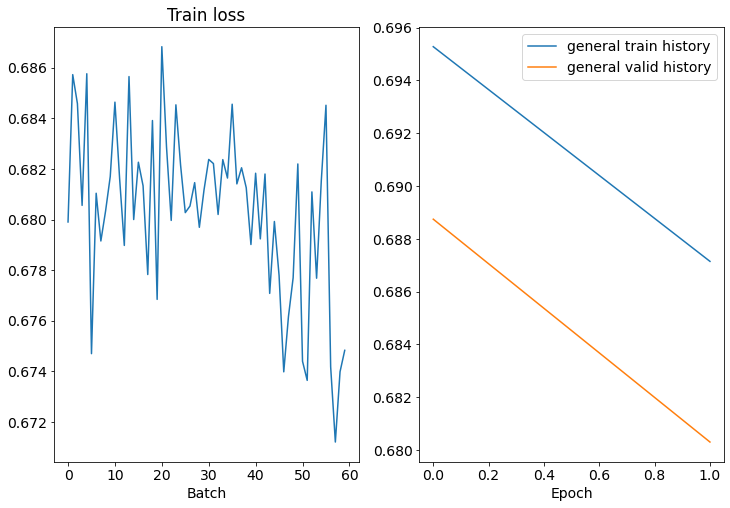

Epoch: 03 | Time: 0m 10s
	Train Loss: 0.680 | Train PPL:   1.974
	 Val. Loss: 0.678 |  Val. PPL:   1.971


In [43]:
N_EPOCHS = 3
CLIP = 1.0


train(True, N_EPOCHS, CLIP, lr=1e-5)

In [44]:
from train_model import punct_detokenize, postprocess


model.load_state_dict(torch.load('novelty_with_weights_best-val-model.pt'))
inference_summarunner_with_novelty = inference_summarunner(model, test_iterator, 3)
inference_summarunner_with_novelty

Count: 256
Ref: заявление эммануэля макрона о « смерти мозга нато » вызвало раздражение и непонимание ангелы меркель . в ходе обеда , посвященного 30-й годовщине падения берлинской стены , канцлер германии заявила французскому коллеге , что устала « склеивать разбитые им чашки » . отношения между странами переживают непростой период , а противоречия лидеров касаются не только целесообразности сохранения военного альянса .
Hyp: отношения франции и германии переживают не лучшие времена из-за противоречий между лидерами стран эммануэлем макроном и ангелой меркель . разногласия политиков касаются сразу нескольких внешнеполитических аспектов , в частности , отношения к нато и его роли в европе . как сообщает the new york times , канцлер германии высказала свое раздражение французскому лидеру в ходе обеда , посвященного 30-й годовщине падения берлинской стены .
BLEU:  0.44795283419371623
ROUGE:  {'rouge-1': {'f': 0.3171462701656167, 'p': 0.3025671151491808, 'r': 0.3533441620058064}, 'rouge-2

In [45]:
from train_model import punct_detokenize, postprocess


model.load_state_dict(torch.load('novelty_with_weights_best-val-model.pt'))
inference_summarunner_with_novelty_and_threshold = inference_summarunner_with_threshold(model, test_iterator, -0.6)
inference_summarunner_with_novelty_and_threshold

Count: 256
Ref: депутат бундестага от « альтернативы для германии » антон фризен заявил , что антироссийские санкции « не вернут крым украине » . по его словам , российский флаг над полуостровом — это реальное положение дел . основным выгодополучателем от санкций против рф является вашингтон , добавил немецкий парламентарий . именно фризен ранее внес законопроект об отмене санкций , но бундестаг отклонил эту инициативу .
Hyp: об этом сообщает риа « новости » . об этом сообщает риа « новости » .
BLEU:  0.40143554772126594
ROUGE:  {'rouge-1': {'f': 0.2752292026809347, 'p': 0.3245232734979655, 'r': 0.25850852101414146}, 'rouge-2': {'f': 0.12021697785427249, 'p': 0.1418515911663989, 'r': 0.11460018158141026}, 'rouge-l': {'f': 0.22828191383546095, 'p': 0.2902917748954956, 'r': 0.22980792379632045}}


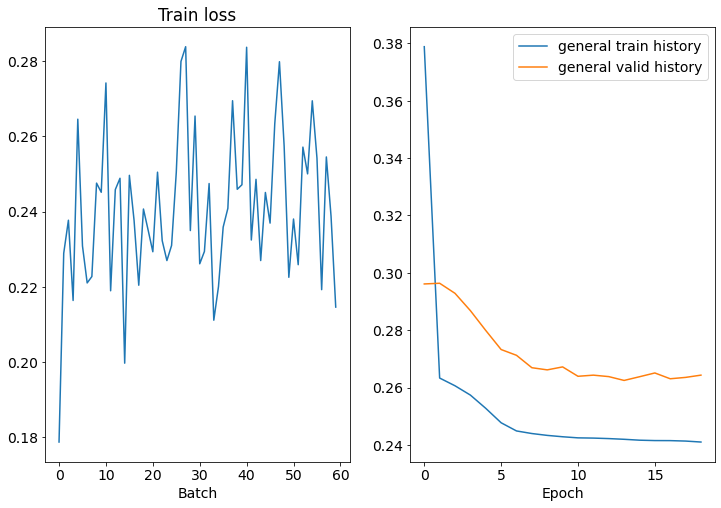

Epoch: 20 | Time: 0m 10s
	Train Loss: 0.241 | Train PPL:   1.273
	 Val. Loss: 0.263 |  Val. PPL:   1.301


In [75]:
!gdown https://drive.google.com/uc?id=1Wr1C3i8hy7TONdJWKhIr0CzqwMySWHN0 -O train_model.py 
import train_model
import imp 
imp.reload(train_model)
from train_model import train_with_logs
train(False, N_EPOCHS=20, CLIP=1.0, lr=0.00001)

## Inference

In [76]:
from train_model import punct_detokenize, postprocess


model.load_state_dict(torch.load('novelty_without_weights_best-val-model.pt'))
inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: на украине открыто признают , что в этом году договор с россией о транзите газа может быть не заключен . переговоры могут продолжиться весной 2020 года . текущий контракт заканчивается в конце года , но стороны никак не могут прийти к компромиссному варианту . киев хочет добиться компенсации от россии по судебным спорам и заключения долгосрочного договора , а москве это не выгодно .
Hyp: глава компании « нафтогаз украины » андрей коболев выразил надежду , что в случае провала переговоров по газу в формате россия - ес - украина в декабре диалог удастся возобновить весной 2020 года . « надеюсь , что даже если контракт не будет подписан сейчас , то в апреле — мае вернемся к этой дискуссии с российской и европейской сторонами » , — цитирует коболева украинское издание « зеркало недели » . по его словам , если сенат сша утвердит санкции по « серверному потоку — 2 » , а президент сша дональд трамп их подпишет , то подписание контракта на транзит газа произойдет в ближайшие не

In [81]:
from train_model import punct_detokenize, postprocess


model.load_state_dict(torch.load('novelty_without_weights_best-val-model.pt'))
inference_summarunner_with_novelty_and_threshold = inference_summarunner_with_threshold(model, test_iterator, -1)
inference_summarunner_with_novelty_and_threshold

Count: 256
Ref: национальная хоккейная лига , приостановившая свой регулярный чемпионат из-за пандемии коронавируса , не собирается аннулировать сезон . руководство лиги и владельцы клубов хотят во что бы то ни стало провести кубок стэнли , иначе экономические последствия будут для команд катастрофическими .
Hyp: все будет зависеть от дальнейшего развития событий . « мы рассматриваем каждую возможную альтернативу .
BLEU:  0.3430638653591284
ROUGE:  {'rouge-1': {'f': 0.23348014521973517, 'p': 0.28533680103614845, 'r': 0.21342717518676912}, 'rouge-2': {'f': 0.0864550596651505, 'p': 0.10640821358067566, 'r': 0.07865415095005145}, 'rouge-l': {'f': 0.19315441516852244, 'p': 0.2574432365427967, 'r': 0.19021300692149165}}
